In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import csv
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Summary

Here we build models that help the Leuven University Fund (LUF) to predict if a donor would donate to the LUF again after donating for the first time to LUF. <br>

The required data for this notebook is obtained using question2_prepared_data.csv file that is generated in 'Data Preparation & Feature Construction.ipynb'. <br>

So far only 3 classifiers are used namely Random Forests, Logistic Regression and SVM with PCA. <br>

The idea is to train the classifier for high recall while minimizing as much false positives as possible. <br>

TODO: Create a Neural Network classifier using keras package

In [3]:
question2_prepared_data = pd.read_csv('SQLDATA/PYTHON_OUTPUTS/question2_prepared_data.csv')
print(question2_prepared_data.shape)
question2_prepared_data = question2_prepared_data.drop(['Unnamed: 0'], axis=1)
print(question2_prepared_data.shape)
question2_prepared_data.head()

(56897, 131)
(56897, 130)


,PARTNER,XSEXF,XSEXM,ZZAMNT_PAYED,ZLUF_DOCDATE,ZZAMNT_PAYED_NORM,ISK_PERSON,ISK_BIRTHPL,ISK_BU_LANGU,ISK_CNT_ORIGIN,...,ZLUF_LIJST,ZLUF_ORG_ALS_PERSOON,ZLUF_ORG_VERENIGING,ZLUF_SCHENKINTERESSE_ARTnCULTURE,ZLUF_SCHENKINTERESSE_CHILDREN,ZLUF_SCHENKINTERESSE_DEVCOOP,ZLUF_SCHENKINTERESSE_HEALTHCARE,ZLUF_SCHENKINTERESSE_HERITAGE,ZLUF_SCHENKINTERESSE_SCHOLARSHIPS,IS_MULTI_DONOR
0,200000002,0,0,1000.0,2004-07-20,1000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,200000007,0,0,4000.0,2010-11-02,4000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,200000010,0,0,100.0,2009-12-22,100.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,200000013,0,0,5000.0,2012-02-28,5000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,200000024,0,0,20000.0,2018-01-03,20000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
question2_prepared_data['IS_MULTI_DONOR'].sum()

14727

14,727 donors out of 56,897 are multi-donors (~26%). <br>

But some of the donors who first donated in the year 2018 might donate again in the future, but this data is not present for now.  <br>

So, in order to improve the performance of the classifier, remove the entries of donors who first donated in the year 2018 using the feature 'ISK_FD_Y_2018'.

In [5]:
question2_prepared_data = question2_prepared_data[question2_prepared_data['ISK_FD_Y_2018']==0]
question2_prepared_data = question2_prepared_data.drop(['ISK_FD_Y_2018'],axis='columns')
print(question2_prepared_data.shape)
question2_prepared_data.head()

(52438, 129)


,PARTNER,XSEXF,XSEXM,ZZAMNT_PAYED,ZLUF_DOCDATE,ZZAMNT_PAYED_NORM,ISK_PERSON,ISK_BIRTHPL,ISK_BU_LANGU,ISK_CNT_ORIGIN,...,ZLUF_LIJST,ZLUF_ORG_ALS_PERSOON,ZLUF_ORG_VERENIGING,ZLUF_SCHENKINTERESSE_ARTnCULTURE,ZLUF_SCHENKINTERESSE_CHILDREN,ZLUF_SCHENKINTERESSE_DEVCOOP,ZLUF_SCHENKINTERESSE_HEALTHCARE,ZLUF_SCHENKINTERESSE_HERITAGE,ZLUF_SCHENKINTERESSE_SCHOLARSHIPS,IS_MULTI_DONOR
0,200000002,0,0,1000.0,2004-07-20,1000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,200000007,0,0,4000.0,2010-11-02,4000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,200000010,0,0,100.0,2009-12-22,100.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,200000013,0,0,5000.0,2012-02-28,5000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,200000035,0,0,15000.0,2007-10-15,15000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


There were 4,459 new donors (56,897-52,438) in the year 2018.

In [6]:
question2_prepared_data['IS_MULTI_DONOR'].sum()

14558

14,558 donors out of 52,438 are multi-donors (~28%). <br>
As you can see the percentage of multi-donors improved when we removed the list of donors who first donated in the year 2018.

In the below cell we remove some of the features that hindered the performance of the classifier

In [7]:
relevant_cols = list(question2_prepared_data.columns.values)
if "PARTNER" in str(relevant_cols):
    relevant_cols.remove("PARTNER")
if "ZLUF_DOCDATE" in str(relevant_cols):
    relevant_cols.remove("ZLUF_DOCDATE")
if "ZZAMNT_PAYED_NORM" in str(relevant_cols):
    relevant_cols.remove("ZZAMNT_PAYED_NORM")
#if "ZZAMNT_PAYED" in str(relevant_cols):
#    relevant_cols.remove("ZZAMNT_PAYED")

if "ISK_FD_CAT_1" in str(relevant_cols):
    relevant_cols.remove("ISK_FD_CAT_1")
if "ISK_FD_CAT_2" in str(relevant_cols):
    relevant_cols.remove("ISK_FD_CAT_2")
if "ISK_FD_CAT_3" in str(relevant_cols):
    relevant_cols.remove("ISK_FD_CAT_3")
if "ISK_FD_CAT_4" in str(relevant_cols):
    relevant_cols.remove("ISK_FD_CAT_4")
if "ISK_FD_CAT_5" in str(relevant_cols):
    relevant_cols.remove("ISK_FD_CAT_5")
if "ISK_FD_CAT_6" in str(relevant_cols):
    relevant_cols.remove("ISK_FD_CAT_6")
    
#if "ISK_FD_SHARED" in str(relevant_cols):
#    relevant_cols.remove("ISK_FD_SHARED")    

In [8]:
train_cols = relevant_cols
if "IS_MULTI_DONOR" in str(train_cols):
    train_cols.remove("IS_MULTI_DONOR")

# Random Forest

In [9]:
#Random Forest baseline
train_X_bl, test_X_bl, train_y_bl, test_y_bl = train_test_split(question2_prepared_data[list(train_cols)], 
                                                    question2_prepared_data['IS_MULTI_DONOR'], test_size = 0.2, random_state = 0)
print(train_X_bl.shape)

rf = RandomForestClassifier()
rf.fit(train_X_bl,train_y_bl)

rf_predictions = rf.predict(test_X_bl)
rf_mc = matthews_corrcoef(rf_predictions, test_y_bl)

df = pd.DataFrame({"a":test_y_bl,"b":rf_predictions})
TP = ((df['a']==df['b']) & (df['a'] == 1)).astype(int).sum(); print('TP = ' + str(TP))
FP = ((df['a']!=df['b']) & (df['a'] == 0)).astype(int).sum(); print('FP = ' + str(FP))
FN = ((df['a']!=df['b']) & (df['a'] == 1)).astype(int).sum(); print('FN = ' + str(FN))
TN = ((df['a']==df['b']) & (df['a'] == 0)).astype(int).sum(); print('TN = ' + str(TN))
Accuracy = (TP+TN)/(TP+TN+FP+FN);print('Accuracy = ' + str(Accuracy))
Precision = TP/(TP+FP); print('Precision = ' + str(Precision))
Recall = TP/(TP+FN); print('Recall = ' + str(Recall))
F1 = 2 * (Precision * Recall) / (Precision + Recall); print('F1 = ' + str(F1))

print('\nMatthews Correlation = ' + str(rf_mc))

(41950, 119)
TP = 1127
FP = 690
FN = 1822
TN = 6849
Accuracy = 0.7604881769641495
Precision = 0.620253164556962
Recall = 0.3821634452356731
F1 = 0.47293327738145197

Matthews Correlation = 0.3452523515330981


## Feature Selection - Random Forest

In [10]:
#Recursive Feature Elimination (RFE)
X, t_X, Y, ty = train_test_split(question2_prepared_data[list(train_cols)], 
                                                    question2_prepared_data['IS_MULTI_DONOR'], test_size = 0.2, random_state = 0)
rf = RandomForestClassifier()
selector_rf = RFECV(rf, cv=5,scoring='recall')  #Tune via recall to get the best performance, in terms of accuracy, recall etc
selector_rf.fit(X, Y)
optimized_columns_rf = X.columns[selector_rf.support_]
print(optimized_columns_rf)

Index(['ZZAMNT_PAYED', 'ISK_COMM_LET', 'ISK_FD_BANKN', 'ISK_FD_VGS',
       'ISK_CC_FD_F', 'NUM_D_TYL', 'ISK_FD_Y_2002', 'REL_ORGCP', 'REL_BUR998',
       'REL_Z00001'],
      dtype='object')


In [11]:
#Random Forest + Feature Selection
train_X, test_X, train_y, test_y = train_test_split(question2_prepared_data[list(optimized_columns_rf)], 
                                                    question2_prepared_data['IS_MULTI_DONOR'], test_size = 0.2, random_state = 0)
print(train_X.shape)

rf = RandomForestClassifier()
rf.fit(train_X,train_y)

rf_predictions = rf.predict(test_X)
rf_mc = matthews_corrcoef(rf_predictions, test_y)

df = pd.DataFrame({"a":test_y,"b":rf_predictions})
TP = ((df['a']==df['b']) & (df['a'] == 1)).astype(int).sum(); print('TP = ' + str(TP))
FP = ((df['a']!=df['b']) & (df['a'] == 0)).astype(int).sum(); print('FP = ' + str(FP))
FN = ((df['a']!=df['b']) & (df['a'] == 1)).astype(int).sum(); print('FN = ' + str(FN))
TN = ((df['a']==df['b']) & (df['a'] == 0)).astype(int).sum(); print('TN = ' + str(TN))
Accuracy = (TP+TN)/(TP+TN+FP+FN);print('Accuracy = ' + str(Accuracy))
Precision = TP/(TP+FP); print('Precision = ' + str(Precision))
Recall = TP/(TP+FN); print('Recall = ' + str(Recall))
F1 = 2 * (Precision * Recall) / (Precision + Recall); print('F1 = ' + str(F1))

print('\nMatthews Correlation = ' + str(rf_mc))

(41950, 10)
TP = 1233
FP = 990
FN = 1716
TN = 6549
Accuracy = 0.7419908466819222
Precision = 0.5546558704453441
Recall = 0.41810783316378436
F1 = 0.4767981438515081

Matthews Correlation = 0.3154773142498958


## Hyper-parameter tuning - Random Forest

In [ ]:
#Hyperparameter Tuning Random forest using different scorers
from sklearn.metrics import roc_curve, f1_score, precision_recall_curve,  auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

criterion = ["entropy","gini"]
min_weight_fraction_leaf = [0.001, 0.0025, 0.005, 0.0075, 0.009, 0.01]
class_weight=['balanced','balanced_subsample', None]
n_estimators = [10, 25, 50, 100, 250]
max_features = ['auto', 'sqrt', 'log2', None]
bootstrap = [True, False]
random_state = [0]
n_jobs=[1]
min_samples_leaf = [0.1, 0.2, 0.3, 0.4, 0.5] #should be >0 & <= 0.5
min_samples_split = [0.1, 0.25, 0.5, 0.75, 0.9, 1.0] #should be >0 & <= 1.0
random_grid = {'criterion': criterion,
               'min_weight_fraction_leaf':min_weight_fraction_leaf,
               'class_weight':class_weight,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'bootstrap': bootstrap,
               'random_state': random_state,
               'n_jobs':n_jobs,
               'min_samples_leaf': min_samples_leaf,
               'min_samples_split': min_samples_split}
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 1000, cv = 5, verbose=2, 
                               random_state=42, n_jobs = -1, scoring=scorers,refit='recall_score')
rf_random.fit(train_X, train_y)
rf_random.best_params_

In [ ]:
results = pd.DataFrame(rf_random.cv_results_)
results = results.sort_values(by='mean_train_accuracy_score', ascending=False)
results = results[['params','mean_test_precision_score','mean_train_precision_score','mean_test_recall_score',
         'mean_train_recall_score','mean_test_accuracy_score','mean_train_accuracy_score','mean_test_f1_score',
         'mean_train_f1_score']]
results.sort_values(by='mean_train_f1_score', ascending=False)
print(results.shape)
results.head()

In [ ]:
results.to_csv('SQLDATA\PYTHON_OUTPUTS\RF_randomizedSearchCV.csv')

In [ ]:
results[results['mean_train_f1_score']>0.45]

In [12]:
#Random Forest + Feature Selection + Hyperparameter Tuning
train_X, test_X, train_y, test_y = train_test_split(question2_prepared_data[list(optimized_columns_rf)], 
                                                    question2_prepared_data['IS_MULTI_DONOR'], test_size = 0.2, random_state = 0)
print(train_X.shape)
rf = RandomForestClassifier(random_state=0, n_estimators=100,min_weight_fraction_leaf=0.009,min_samples_split=0.1,
                            min_samples_leaf=0.1,max_features='auto',criterion='gini',class_weight='balanced_subsample',
                            bootstrap=True)
rf.fit(train_X,train_y)

rf_predictions = rf.predict(test_X)
rf_mc = matthews_corrcoef(rf_predictions, test_y)

df = pd.DataFrame({"a":test_y,"b":rf_predictions})
TP = ((df['a']==df['b']) & (df['a'] == 1)).astype(int).sum(); print('TP = ' + str(TP))
FP = ((df['a']!=df['b']) & (df['a'] == 0)).astype(int).sum(); print('FP = ' + str(FP))
FN = ((df['a']!=df['b']) & (df['a'] == 1)).astype(int).sum(); print('FN = ' + str(FN))
TN = ((df['a']==df['b']) & (df['a'] == 0)).astype(int).sum(); print('TN = ' + str(TN))
Accuracy = (TP+TN)/(TP+TN+FP+FN);print('Accuracy = ' + str(Accuracy))
Precision = TP/(TP+FP); print('Precision = ' + str(Precision))
Recall = TP/(TP+FN); print('Recall = ' + str(Recall))
F1 = 2 * (Precision * Recall) / (Precision + Recall); print('F1 = ' + str(F1))

print('\nMatthews Correlation: ' + str(rf_mc))

(41950, 10)
TP = 1792
FP = 2980
FN = 1157
TN = 4559
Accuracy = 0.6055491990846682
Precision = 0.3755238893545683
Recall = 0.6076636147846728
F1 = 0.4641885766092475

Matthews Correlation: 0.1917446506460992


Text(0.5, 0, 'Features')

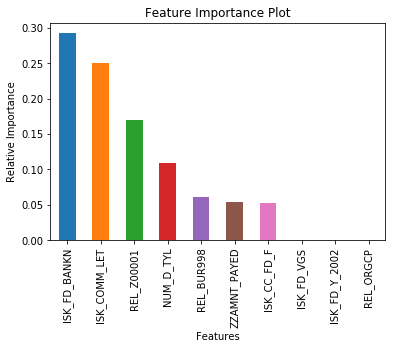

In [13]:
feat_importances = pd.Series(rf.feature_importances_, index=list(optimized_columns_rf))
feat_importances.nlargest(25).plot(kind='bar')
plt.title('Feature Importance Plot')
plt.ylabel('Relative Importance')
plt.xlabel('Features')

Plot a correlation plot with the top 25 features with highest feature importance used by Random Forest Classifier.

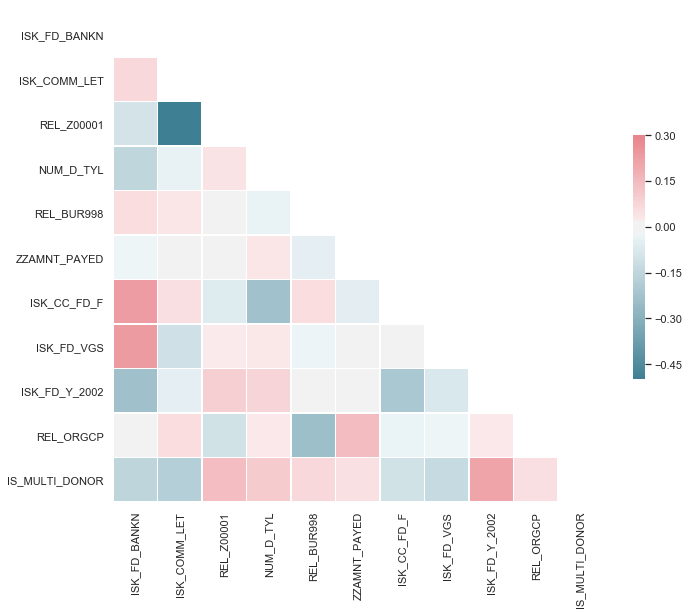

In [14]:
rg_top25_coeffs_cols = list(feat_importances.nlargest(25).index) + ['IS_MULTI_DONOR']
def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

plot_correlation_heatmap(question2_prepared_data[rg_top25_coeffs_cols])

# Logistic Regression

In [15]:
#Logistic Regression Baseline
train_X_bl, test_X_bl, train_y_bl, test_y_bl = train_test_split(question2_prepared_data[list(train_cols)], 
                                                    question2_prepared_data['IS_MULTI_DONOR'], test_size = 0.2, random_state = 0)
print(train_X_bl.shape)

lr = LogisticRegression()
lr.fit(train_X_bl,train_y_bl)

lr_predictions = lr.predict(test_X_bl)
lr_mc = matthews_corrcoef(lr_predictions, test_y_bl)
df = pd.DataFrame({"a":test_y,"b":lr_predictions})
TP = ((df['a']==df['b']) & (df['a'] == 1)).astype(int).sum(); print('TP = ' + str(TP))
FP = ((df['a']!=df['b']) & (df['a'] == 0)).astype(int).sum(); print('FP = ' + str(FP))
FN = ((df['a']!=df['b']) & (df['a'] == 1)).astype(int).sum(); print('FN = ' + str(FN))
TN = ((df['a']==df['b']) & (df['a'] == 0)).astype(int).sum(); print('TN = ' + str(TN))
Accuracy = (TP+TN)/(TP+TN+FP+FN);print('Accuracy = ' + str(Accuracy))
Precision = TP/(TP+FP); print('Precision = ' + str(Precision))
Recall = TP/(TP+FN); print('Recall = ' + str(Recall))
F1 = 2 * (Precision * Recall) / (Precision + Recall); print('F1 = ' + str(F1))

print('\nMatthews Correlation: ')
print(lr_mc)

(41950, 119)
TP = 951
FP = 360
FN = 1998
TN = 7179
Accuracy = 0.7751716247139588
Precision = 0.7254004576659039
Recall = 0.3224821973550356
F1 = 0.44647887323943664

Matthews Correlation: 
0.3734645917065487


## Feature Selection - Logistic Regression

In [16]:
#Recursive Feature Elimination (RFE) 
X, t_X, Y, ty = train_test_split(question2_prepared_data[list(train_cols)], 
                                 question2_prepared_data['IS_MULTI_DONOR'], test_size = 0.2, random_state = 0)

lr = LogisticRegression()
selector_lr = RFECV(lr, cv=5,scoring='recall')
selector_lr.fit(X, Y)
optimized_columns_lr = X.columns[selector_lr.support_]
print(optimized_columns_lr)

Index(['XSEXF', 'XSEXM', 'ISK_PERSON', 'ISK_BIRTHPL', 'ISK_BU_LANGU',
       'ISK_CNT_ORIGIN', 'ISK_NATIONALITY', 'ISK_VOORNAAM', 'ISK_LANGU_CORR',
       'ISK_MARST',
       ...
       'ZLUF_KERKELIJK', 'ZLUF_LIJST', 'ZLUF_ORG_ALS_PERSOON',
       'ZLUF_ORG_VERENIGING', 'ZLUF_SCHENKINTERESSE_ARTnCULTURE',
       'ZLUF_SCHENKINTERESSE_CHILDREN', 'ZLUF_SCHENKINTERESSE_DEVCOOP',
       'ZLUF_SCHENKINTERESSE_HEALTHCARE', 'ZLUF_SCHENKINTERESSE_HERITAGE',
       'ZLUF_SCHENKINTERESSE_SCHOLARSHIPS'],
      dtype='object', length=118)


In [17]:
#Logistic Regression + Feature Selection
train_X_fs, test_X_fs, train_y_fs, test_y_fs = train_test_split(question2_prepared_data[list(optimized_columns_lr)], 
                                                    question2_prepared_data['IS_MULTI_DONOR'], test_size = 0.2, random_state = 0)
print(test_X_fs.shape)

lr = LogisticRegression()
lr.fit(train_X_fs,train_y_fs)

lr_predictions = lr.predict(test_X_fs)
lr_mc = matthews_corrcoef(lr_predictions, test_y_fs)
df = pd.DataFrame({"a":test_y,"b":lr_predictions})
TP = ((df['a']==df['b']) & (df['a'] == 1)).astype(int).sum(); print('TP = ' + str(TP))
FP = ((df['a']!=df['b']) & (df['a'] == 0)).astype(int).sum(); print('FP = ' + str(FP))
FN = ((df['a']!=df['b']) & (df['a'] == 1)).astype(int).sum(); print('FN = ' + str(FN))
TN = ((df['a']==df['b']) & (df['a'] == 0)).astype(int).sum(); print('TN = ' + str(TN))
Accuracy = (TP+TN)/(TP+TN+FP+FN);print('Accuracy = ' + str(Accuracy))
Precision = TP/(TP+FP); print('Precision = ' + str(Precision))
Recall = TP/(TP+FN); print('Recall = ' + str(Recall))
F1 = 2 * (Precision * Recall) / (Precision + Recall); print('F1 = ' + str(F1))

print('\nMatthews Correlation: ' + str(lr_mc))

(10488, 118)
TP = 950
FP = 363
FN = 1999
TN = 7176
Accuracy = 0.774790236460717
Precision = 0.7235338918507236
Recall = 0.3221430993557138
F1 = 0.4458000938526513

Matthews Correlation: 0.3722194668113831


## Hyper-parameter tuning - Logistic Regression

In [ ]:
#Hyper-parameter tuning for Logistic Regression using RamdomizedSearchCV
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}
tol=[0.0001,0.001,0.005,0.01,0.05,0.1]
c = [1.0,2.0,5.0]
fit_intercept = [True,False]
intercept_scaling = [1,2,5,10]
class_weight = ['balanced',None]
solver = ['newton-cg', 'lbfgs', 'liblinear']
max_iter = [20,50,100,200]
random_grid = {'tol': tol,
               'C': c,
               'fit_intercept': fit_intercept,
               'intercept_scaling': intercept_scaling,
               'class_weight': class_weight,
               'solver': solver,
               'max_iter': max_iter}
lr = LogisticRegression()
lr_random = RandomizedSearchCV(estimator = lr, param_distributions = random_grid, n_iter = 500, cv = 5, verbose=2, 
                               random_state=42, n_jobs = -1,scoring=scorers,refit='recall_score')
lr_random.fit(train_X, train_y)
lr_random.best_params_

In [ ]:
results = pd.DataFrame(lr_random.cv_results_)
results = results.sort_values(by='mean_train_accuracy_score', ascending=False)
results = results[['params','mean_test_precision_score','mean_train_precision_score','mean_test_recall_score',
         'mean_train_recall_score','mean_test_accuracy_score','mean_train_accuracy_score','mean_test_f1_score',
         'mean_train_f1_score']]
results.sort_values(by='mean_train_f1_score', ascending=False)
results.to_csv('SQLDATA\PYTHON_OUTPUTS\LR_randomizedSearchCV.csv')
print(results.shape)
results.head()

In [18]:
#Logistic Regression + Feature Selection + Hyperparameter Tuning
train_X, test_X, train_y, test_y = train_test_split(question2_prepared_data[list(optimized_columns_lr)], 
                                                    question2_prepared_data['IS_MULTI_DONOR'], test_size = 0.2, random_state = 0)
print(test_X.shape)
#lr = LogisticRegression(tol=0.001,solver='liblinear',max_iter=50,intercept_scaling=1,fit_intercept=True,class_weight='balanced',C=1.0)
lr = LogisticRegression(tol=0.01,solver='lbfgs',max_iter=100,intercept_scaling=10,fit_intercept=True,
                       class_weight='balanced',C=2.0)
lr.fit(train_X,train_y)

lr_predictions = lr.predict(test_X)
lr_mc = matthews_corrcoef(lr_predictions, test_y)
df = pd.DataFrame({"a":test_y,"b":lr_predictions})
TP = ((df['a']==df['b']) & (df['a'] == 1)).astype(int).sum(); print('TP = ' + str(TP))
FP = ((df['a']!=df['b']) & (df['a'] == 0)).astype(int).sum(); print('FP = ' + str(FP))
FN = ((df['a']!=df['b']) & (df['a'] == 1)).astype(int).sum(); print('FN = ' + str(FN))
TN = ((df['a']==df['b']) & (df['a'] == 0)).astype(int).sum(); print('TN = ' + str(TN))
Accuracy = (TP+TN)/(TP+TN+FP+FN);print('Accuracy = ' + str(Accuracy))
Precision = TP/(TP+FP); print('Precision = ' + str(Precision))
Recall = TP/(TP+FN); print('Recall = ' + str(Recall))
F1 = 2 * (Precision * Recall) / (Precision + Recall); print('F1 = ' + str(F1))

print('\nMatthews Correlation: ' + str(lr_mc))

(10488, 118)
TP = 1876
FP = 2264
FN = 1073
TN = 5275
Accuracy = 0.6818268497330282
Precision = 0.45314009661835747
Recall = 0.6361478467277043
F1 = 0.5292707010861899

Matthews Correlation: 0.308895532375653


In [19]:
lr_coef = lr.coef_
lr_coef = [np.abs(item) for sublist in lr_coef for item in sublist]
coef_weights = pd.DataFrame({"Cols":list(optimized_columns_lr),"Coef":lr_coef})
coef_weights = coef_weights.sort_values("Coef",ascending=False)
coef_weights.reset_index(drop=True,inplace=True)
coef_weights.head()

,Cols,Coef
0,ISK_FD_Y_2002,1.169091
1,ISK_COMM_LET,0.862232
2,ISK_VOORNAAM,0.778083
3,REL_ORGCP,0.752800
4,REL_BUR998,0.678715


Plot a correlation plot with the top 25 features with highest absolute weight coefficients from Logitstic Regression Classifier.

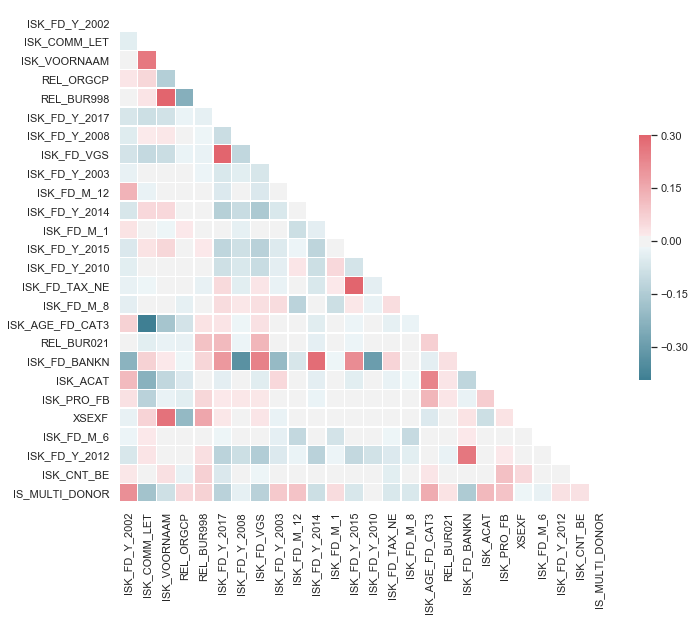

In [20]:
lr_top25_coeffs_cols = list(coef_weights['Cols'][:25]) + ['IS_MULTI_DONOR']

def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

plot_correlation_heatmap(question2_prepared_data[lr_top25_coeffs_cols])

One reason why ISK_FD_Y_2002 (Is the first donation in 2002) is correlated with being a multi-donor is because of the archaelogical credit (Sagalassos Research Project). <br>
There is a negative correlation of ISK_FD_Y_2018 (Is the first donation in 2018) with being a multi-donor and it is expected because some of the multi-donors take time to donate again. Some multi-donors who first made a donation in 2018 might donate again in 2018 but the majority of them don't.  

## Apply PCA & Classify using SVM

In [21]:
#Apply PCA
train_X, test_X, train_y, test_y = train_test_split(question2_prepared_data[train_cols], 
                                                    question2_prepared_data['IS_MULTI_DONOR'], test_size = 0.2, random_state = 0)
n_components = 30      #30 seems optimal. 20 is good as well 
# Standardizing the features
#train_X = StandardScaler().fit_transform(train_X)
#test_X = StandardScaler().fit_transform(test_X)
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(train_X)

X_train_pca = pca.transform(train_X)
X_test_pca = pca.transform(test_X)

In [22]:
#SVM
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
#clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, scoring='f1')   #Takes time. Didn't finish after 2 hours
clf = SVC(kernel='rbf', class_weight='balanced')
clf = clf.fit(X_train_pca, train_y)
#print("Best estimator found by grid search:")
#print(clf.best_estimator_)
svm_predictions = clf.predict(X_test_pca)

svm_mc = matthews_corrcoef(svm_predictions, test_y)

df = pd.DataFrame({"a":test_y,"b":svm_predictions})
TP = ((df['a']==df['b']) & (df['a'] == 1)).astype(int).sum(); print('TP = ' + str(TP))
FP = ((df['a']!=df['b']) & (df['a'] == 0)).astype(int).sum(); print('FP = ' + str(FP))
FN = ((df['a']!=df['b']) & (df['a'] == 1)).astype(int).sum(); print('FN = ' + str(FN))
TN = ((df['a']==df['b']) & (df['a'] == 0)).astype(int).sum(); print('TN = ' + str(TN))
Accuracy = (TP+TN)/(TP+TN+FP+FN);print('Accuracy = ' + str(Accuracy))
Precision = TP/(TP+FP); print('Precision = ' + str(Precision))
Recall = TP/(TP+FN); print('Recall = ' + str(Recall))
F1 = 2 * (Precision * Recall) / (Precision + Recall); print('F1 = ' + str(F1))

print('\nMatthews Correlation: ' + str(svm_mc))

TP = 1836
FP = 1801
FN = 1113
TN = 5738
Accuracy = 0.7221586575133486
Precision = 0.504811657959857
Recall = 0.6225839267548321
F1 = 0.5575463103552991

Matthews Correlation: 0.3624343103941259


In [23]:
print(abs( pca.components_[0]>0.5)) #3rd component corresponds to 'ISK_PERSON' feature

[False False  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False]


<b>SVM</b> produced the best results according to the requirement. <br>
It produced a recall of 62% achieving an accuracy of ~72%, meaning it was able to capture almost 2/3rd of donors who would become multi-donors in the future while minimizing false positives as much as possible. <br>

Next steps: <br>
- Try to extract some more features using the LUF data.
- Try other classifiers including Neural Network via Keras.